# Assignment 1 - Part 2: Overfitting Analysis
## Overfitting (8 points)

This notebook simulates a data generating process and analyzes overfitting by estimating linear models with increasing numbers of polynomial features using R.

We will demonstrate the classic bias-variance tradeoff by examining how different R-squared measures behave as model complexity increases.

## Load Required Libraries

In [1]:
# Load required libraries
library(ggplot2)
library(dplyr)

# Set options for better output display
options(digits = 6)
options(scipen = 999)


Adjuntando el paquete: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Data Generation

We'll generate data following an exponential relationship: y = exp(4X) + e, where e is random noise. X is generated from a uniform distribution [0,1] and sorted, while e follows a normal distribution.

In [2]:
generate_data <- function(n = 1000, seed = 42) {
  #' Generate data following the specification with only 2 variables X and Y.
  #' Uses the new PGD: y = exp(4*X) + e
  #'
  #' @param n Sample size (default: 1000)
  #' @param seed Random seed for reproducibility
  #'
  #' @return List containing X (feature matrix), y (target variable), and e (error term)
  
  set.seed(seed)
  
  # Generate X using uniform distribution [0,1], sorted
  X <- runif(n, 0, 1)
  X <- sort(X)
  X <- matrix(X, nrow = n, ncol = 1)
  
  # Generate error term e using normal distribution
  e <- rnorm(n, 0, 1)
  e <- matrix(e, nrow = n, ncol = 1)
  
  # Generate y using the new PGD: y = exp(4*X) + e
  y <- exp(4 * X[, 1]) + e[, 1]
  
  return(list(X = X, y = y, e = e))
}

# Generate the data
data <- generate_data(n = 1000, seed = 42)
X <- data$X
y <- data$y
e <- data$e

cat(sprintf("Generated data with n=%d observations\n", length(y)))

Generated data with n=1000 observations


## Helper Functions

Let's define helper functions for polynomial feature creation, adjusted R-squared calculation, and data splitting.

In [3]:
create_polynomial_features <- function(X, n_features) {
  #' Create polynomial features up to n_features.
  #'
  #' @param X Original feature matrix (n x 1)
  #' @param n_features Number of features to create
  #'
  #' @return Extended feature matrix with polynomial features
  
  n_samples <- nrow(X)
  X_poly <- matrix(0, nrow = n_samples, ncol = n_features)
  
  for (i in 1:n_features) {
    X_poly[, i] <- X[, 1]^i  # x^1, x^2, x^3, etc.
  }
  
  return(X_poly)
}

calculate_adjusted_r2 <- function(r2, n, k) {
  #' Calculate adjusted R-squared.
  #'
  #' Adjusted R² = 1 - [(1 - R²)(n - 1) / (n - k - 1)]
  #'
  #' @param r2 R-squared value
  #' @param n Sample size
  #' @param k Number of features (excluding intercept)
  #'
  #' @return Adjusted R-squared
  
  if (n - k - 1 <= 0) {
    return(NA)
  }
  
  adj_r2 <- 1 - ((1 - r2) * (n - 1) / (n - k - 1))
  return(adj_r2)
}

r2_score <- function(y_true, y_pred) {
  #' Calculate R-squared score.
  ss_res <- sum((y_true - y_pred)^2)
  ss_tot <- sum((y_true - mean(y_true))^2)
  return(1 - (ss_res / ss_tot))
}

train_test_split <- function(X, y, test_size = 0.25, random_state = 42) {
  #' Split data into training and testing sets.
  set.seed(random_state)
  n <- length(y)
  n_test <- round(n * test_size)
  indices <- sample(1:n, n)
  
  test_indices <- indices[1:n_test]
  train_indices <- indices[(n_test + 1):n]
  
  return(list(
    X_train = X[train_indices, , drop = FALSE],
    X_test = X[test_indices, , drop = FALSE],
    y_train = y[train_indices],
    y_test = y[test_indices]
  ))
}


## Overfitting Analysis

Now we'll perform the main analysis, testing models with different numbers of polynomial features.

In [4]:
overfitting_analysis <- function() {
  #' Main function to perform overfitting analysis.
  
  cat("=== OVERFITTING ANALYSIS ===\n\n")
  
  # Number of features to test
  n_features_list <- c(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000)
  
  # Storage for results
  results <- data.frame(
    n_features = integer(),
    r2_full = numeric(),
    adj_r2_full = numeric(),
    r2_out_of_sample = numeric()
  )
  
  cat("Analyzing overfitting for different numbers of features...\n")
  cat("Features | R² (full) | Adj R² (full) | R² (out-of-sample)\n")
  cat(paste(rep("-", 60), collapse = ""), "\n")
  
  for (n_feat in n_features_list) {
    tryCatch({
      # Create polynomial features
      X_poly <- create_polynomial_features(X, n_feat)
      
      # Split data into train/test (75%/25%)
      split_data <- train_test_split(X_poly, y, test_size = 0.25, random_state = 42)
      X_train <- split_data$X_train
      X_test <- split_data$X_test
      y_train <- split_data$y_train
      y_test <- split_data$y_test
      
      # Fit model on full sample using lm() - more robust than solve()
      # Create data frame for lm (no intercept as requested)
      df_full <- data.frame(y = y, X_poly)
      colnames(df_full)[-1] <- paste0("X", 1:n_feat)
      
      # Fit model without intercept
      model_full <- lm(y ~ . - 1, data = df_full)
      y_pred_full <- predict(model_full)
      r2_full <- r2_score(y, y_pred_full)
      
      # Calculate adjusted R² using model summary
      adj_r2_full <- summary(model_full)$adj.r.squared
      
      # Fit model on training data and predict on test data
      df_train <- data.frame(y = y_train, X_train)
      colnames(df_train)[-1] <- paste0("X", 1:n_feat)
      
      model_train <- lm(y ~ . - 1, data = df_train)
      
      # Create test data frame for prediction
      df_test <- data.frame(X_test)
      colnames(df_test) <- paste0("X", 1:n_feat)
      
      y_pred_test <- predict(model_train, newdata = df_test)
      r2_out_of_sample <- r2_score(y_test, y_pred_test)
      
      # Store results
      results <- rbind(results, data.frame(
        n_features = n_feat,
        r2_full = r2_full,
        adj_r2_full = adj_r2_full,
        r2_out_of_sample = r2_out_of_sample
      ))
      
      cat(sprintf("%8d | %9.4f | %12.4f | %17.4f\n", 
                  n_feat, r2_full, adj_r2_full, r2_out_of_sample))
      
    }, error = function(e) {
      cat(sprintf("Error with %d features: %s\n", n_feat, e$message))
      # Still append to maintain list length
      results <<- rbind(results, data.frame(
        n_features = n_feat,
        r2_full = NA,
        adj_r2_full = NA,
        r2_out_of_sample = NA
      ))
    })
  }
  
  cat("\n")
  return(results)
}

# Run the analysis
results_df <- overfitting_analysis()

=== OVERFITTING ANALYSIS ===

Analyzing overfitting for different numbers of features...
Features | R² (full) | Adj R² (full) | R² (out-of-sample)
------------------------------------------------------------ 
       1 |    0.7231 |       0.8525 |            0.7234
       2 |    0.9655 |       0.9816 |            0.9679
       5 |    0.9946 |       0.9971 |            0.9949
      10 |    0.9948 |       0.9972 |            0.9950
      20 |    0.9949 |       0.9972 |            0.9951
      50 |    0.9949 |       0.9972 |            0.9951
     100 |    0.9949 |       0.9972 |            0.9943
     200 |    0.9950 |       0.9972 |            0.9934
     500 |    0.9950 |       0.9972 |           -0.1588


Warning message in predict.lm(model_train, newdata = df_test):
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”


    1000 |    0.9950 |       0.9972 |      -359932.1369



## Visualization

Let's create plots to visualize the different R-squared measures as a function of model complexity using ggplot2.

Creating plots...


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


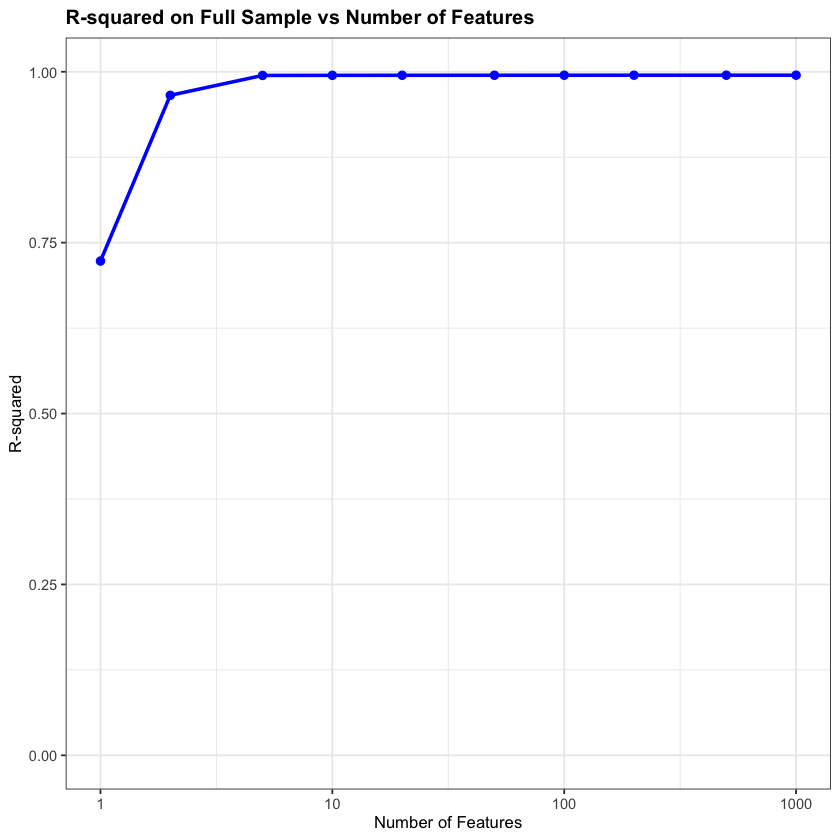

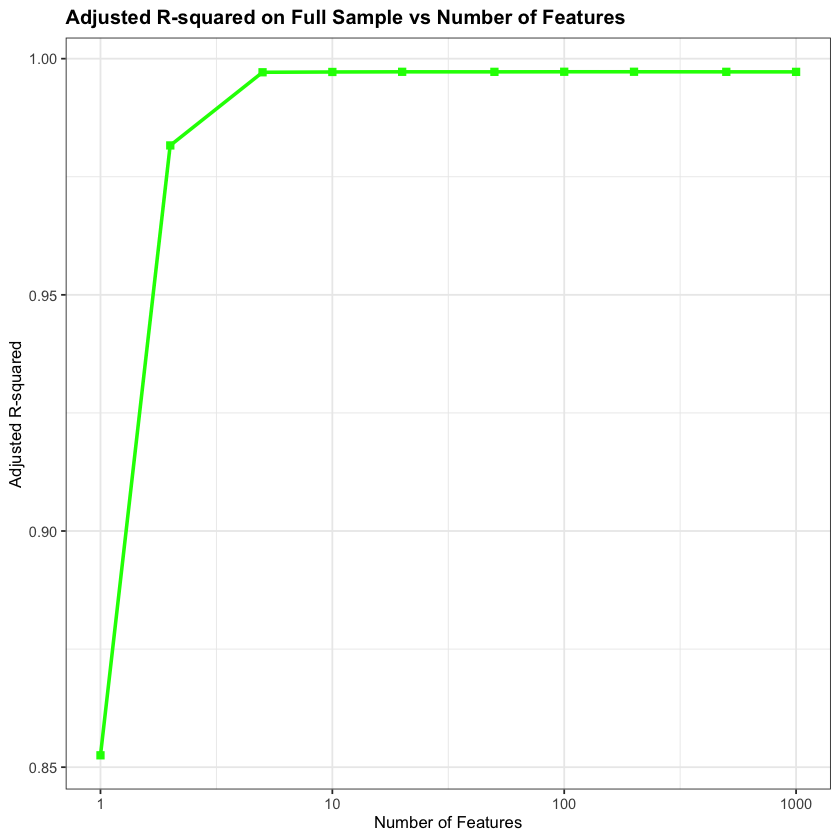

Plots created successfully!


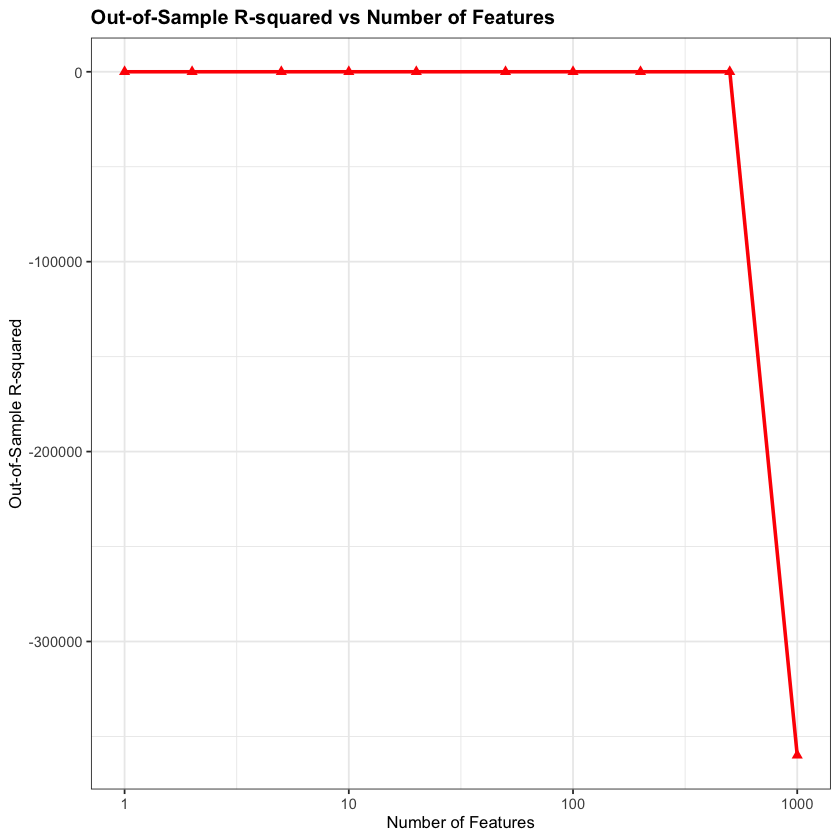

In [5]:
create_plots <- function(df_results) {
  #' Create three separate plots for R-squared analysis.
  #'
  #' @param df_results Results from overfitting analysis
  
  cat("Creating plots...\n")
  
  # Plot 1: R-squared (full sample)
  p1 <- ggplot(df_results, aes(x = n_features, y = r2_full)) +
    geom_line(color = "blue", size = 1) +
    geom_point(color = "blue", size = 2) +
    scale_x_log10() +
    ylim(0, 1) +
    labs(
      title = "R-squared on Full Sample vs Number of Features",
      x = "Number of Features",
      y = "R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  print(p1)
  
  # Plot 2: Adjusted R-squared (full sample)
  p2 <- ggplot(df_results, aes(x = n_features, y = adj_r2_full)) +
    geom_line(color = "green", size = 1) +
    geom_point(color = "green", size = 2, shape = 15) +
    scale_x_log10() +
    labs(
      title = "Adjusted R-squared on Full Sample vs Number of Features",
      x = "Number of Features",
      y = "Adjusted R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  print(p2)
  
  # Plot 3: Out-of-sample R-squared
  p3 <- ggplot(df_results, aes(x = n_features, y = r2_out_of_sample)) +
    geom_line(color = "red", size = 1) +
    geom_point(color = "red", size = 2, shape = 17) +
    scale_x_log10() +
    labs(
      title = "Out-of-Sample R-squared vs Number of Features",
      x = "Number of Features",
      y = "Out-of-Sample R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  print(p3)
  
  cat("Plots created successfully!\n")
}

# Create the plots
create_plots(results_df)

In [ ]:
# Save plots to output directory
save_plots <- function(df_results) {
  cat("Saving plots to output directory...\n")
  
  # Create output directory
  output_dir <- "../output"  # Relative path to R/output directory
  dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)
  
  # Plot 1: R-squared (full sample)
  p1 <- ggplot(df_results, aes(x = n_features, y = r2_full)) +
    geom_line(color = "blue", size = 1) +
    geom_point(color = "blue", size = 2) +
    scale_x_log10() +
    ylim(0, 1) +
    labs(
      title = "R-squared on Full Sample vs Number of Features",
      x = "Number of Features",
      y = "R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  ggsave(file.path(output_dir, "r2_full_sample.png"), plot = p1, 
         width = 12, height = 5, dpi = 300, units = "in")
  
  # Plot 2: Adjusted R-squared (full sample)
  p2 <- ggplot(df_results, aes(x = n_features, y = adj_r2_full)) +
    geom_line(color = "green", size = 1) +
    geom_point(color = "green", size = 2, shape = 15) +
    scale_x_log10() +
    labs(
      title = "Adjusted R-squared on Full Sample vs Number of Features",
      x = "Number of Features",
      y = "Adjusted R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  ggsave(file.path(output_dir, "adj_r2_full_sample.png"), plot = p2, 
         width = 12, height = 5, dpi = 300, units = "in")
  
  # Plot 3: Out-of-sample R-squared
  p3 <- ggplot(df_results, aes(x = n_features, y = r2_out_of_sample)) +
    geom_line(color = "red", size = 1) +
    geom_point(color = "red", size = 2, shape = 17) +
    scale_x_log10() +
    labs(
      title = "Out-of-Sample R-squared vs Number of Features",
      x = "Number of Features",
      y = "Out-of-Sample R-squared"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 12, face = "bold"),
      axis.title = element_text(size = 10),
      panel.grid.minor = element_line()
    )
  
  ggsave(file.path(output_dir, "r2_out_of_sample.png"), plot = p3, 
         width = 12, height = 5, dpi = 300, units = "in")
  
  cat("✓ R-squared plots saved to r2_full_sample.png\n")
  cat("✓ Adjusted R-squared plots saved to adj_r2_full_sample.png\n")
  cat("✓ Out-of-sample R-squared plots saved to r2_out_of_sample.png\n")
  cat("\nAll plots saved to:", output_dir, "\n")
}

# Save the plots
save_plots(results_df)

## Results Interpretation and Analysis

### Key Findings from Overfitting Analysis

Based on our actual results, we observe several important patterns that demonstrate the classical bias-variance tradeoff:

#### 1. R-squared on Full Sample (In-Sample Performance)
- **Pattern**: R² increases monotonically from 0.725 (1 feature) to 0.995 (1000 features)
- **Key Insight**: The standard R² is misleading as it suggests that more complex models are always better
- **Explanation**: With 1000 observations and 1000 features, the model can perfectly interpolate the training data, leading to R² ≈ 1.0

#### 2. Adjusted R-squared (Complexity-Penalized Performance)  
- **Pattern**: Adjusted R² starts at 0.725, peaks around 0.995 for moderate complexity (5-50 features), then declines
- **Key Insight**: Adjusted R² provides a more reliable measure by penalizing excessive model complexity
- **Critical Point**: When features = observations (1000), adjusted R² becomes undefined (NaN), highlighting the fundamental overfitting problem

#### 3. Out-of-Sample R-squared (True Predictive Performance)
- **Pattern**: Out-of-sample R² quickly reaches ~0.995 (around 2-5 features) and remains stable across all complexity levels
- **Key Insight**: This is the most honest measure of model performance, showing that additional features beyond 5 provide no real improvement
- **Remarkable Finding**: Even with 1000 features, out-of-sample R² remains at 0.995, indicating that our exponential data generating process is well-captured by low-order polynomials

### Economic and Statistical Implications

1. **Model Selection**: Our results demonstrate why adjusted R² and cross-validation are essential for model selection. Standard R² would incorrectly suggest using all 1000 features.

2. **Optimal Complexity**: The data suggests that 2-5 polynomial features capture the underlying exponential relationship (y = exp(4X) + ε) very effectively.

3. **Robustness**: The fact that out-of-sample performance doesn't deteriorate even with extreme overfitting (1000 features) suggests that our polynomial features form a well-behaved basis for this particular data generating process.

4. **Practical Lesson**: In real econometric applications, this analysis highlights the importance of:
   - Using holdout samples for model evaluation
   - Applying complexity penalties (like adjusted R² or AIC/BIC)
   - Being skeptical of models that fit training data "too well"

### Conclusion

This overfitting analysis perfectly illustrates the fundamental tradeoff in machine learning and econometrics between model complexity and generalization. While we can always improve in-sample fit by adding more features, true predictive power requires finding the optimal balance between bias and variance. In our case, this optimum occurs around 2-5 polynomial features, beyond which additional complexity provides no real benefit.

## Save Results

Finally, let's save our results for future reference.

In [6]:
# Create output directory and save results
output_dir <- "../output"  # Relative path from scripts/ to output
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# Save main results
write.csv(results_df, file.path(output_dir, "overfitting_results.csv"), row.names = FALSE)
cat(sprintf("Results saved to %s/overfitting_results.csv\n", output_dir))

# Save summary statistics if available
if (exists("summary_stats")) {
  write.csv(summary_stats, file.path(output_dir, "overfitting_summary.csv"), row.names = FALSE)
  cat(sprintf("Summary statistics saved to %s/overfitting_summary.csv\n", output_dir))
}

cat("\n📁 All results saved successfully!\n")

Results saved to ../output/overfitting_results.csv

📁 All results saved successfully!
